# ECON 407 Project: The SIR-Macro Model

<b>Professor Peifan Wu</b>

<b>Jack (Quan Cheng) Xie</b> <br>
Student #: 31091325

December 6, 2020

---

The focus of this project is to recreate the model SIR-Macro model introduced in "The Macroeconomics of Epidemics" by Eichenbaumn, Rebelo, Trabandt (2020) that we looked at in class.

In [1]:
# imports
import numpy as np
from numba import njit
import pickle

from datetime import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

from IPython.display import clear_output

In [2]:
# formatting
textbf = lambda x: '\033[5m' + str(x) + '\033[0m'
cmap = plt.get_cmap('autumn_r') # color map

<a id='contents'></a>

---

# Contents

**1. [The Pre-infection Economy](#pre-infection-econ)**
* Define pre-infection economy model.
* Solve pre-infection model.

**2. [Epidemic Dynamics](#epidemic-dynamics)**
* Define population dynamics in the SIR-Macro model.

**3. [Household Dynamics](#epidemic-household)**
* Define the households' policy functions in the SIR-Macro model.
* Solve the households' policy functions. Analysis is provided in the next section.

**4. [Household Dynamics Results](#household-results)**
* Analysis of the agents' policy functions.

**5. [Epidemic Simulation](#ee-sim)**
* Simulation of epidemic progression and agent labor choices.



<br>

### Appendices
* **[Appendix A:](#appendix-pre-infection)** FOC of Pre-infection Agent

* **[Appendix B:](#appendix-recovered)** FOC of Recovered Agent

* **[Appendix C:](#appendix-infected)** FOC of Infected Agent

* **[Appendix D:](#appendix-susceptible)** FOC of Susceptible Agent


<!--
**#. [name](#tag)**


<a id='dynamics-results'></a>

---
[**Back to Contents**](#contents)
 -->

<a id="pre-infection-econ"></a>

---
[**Back to Contents**](#contents)


# 1: The Pre-infection Economy

This section defines the economic model that is the basis of the simple SIR-Macro model. We solve the representative household policy function in pre-epidemic conditions.


### Households

The representative household maximizes life-time utility:
$$
\begin{equation*}
    U_{t} = \sum_{t=0}^{\infty} \beta^t u(c_t, n_t) = u(c_t, n_t) + \beta U_{t+1}
\tag{1.1}
\end{equation*}
$$
where $\beta \in (0, 1)$ is the discount factor, $c_t$ is consumption, and $n_t$ is labor (hours worked).


The household has the utility function:
$$
\begin{equation*}
    u(c_t, n_t) = \ln(c_t) - \frac{\theta}{2}n^2_t.
\tag{1.2}
\end{equation*}
$$

The household's budget constraint is
$$
\begin{equation*}
        (1 + \mu_t)c_t = w_t n_t + \Gamma_t,
\tag{1.3}
\end{equation*}
$$

where $w_t$ is wage rate, $\mu_t$ is tax rate on consumption, and $\Gamma_t$ is transfer from the government.


### Firms

A continuum of representative firm produces consumption goods $C_t$ with labor $N_t$ and technology $A$:

$$
\begin{align}
    C_t = A N_t
\end{align}
$$

and chooses labor to maximize profits:

$$
\begin{align}
    \Pi_t = A N_t - w_t N_t.
\end{align}
$$


### Government

The government's budget constraint is given by:
$$
\begin{align}
    \mu_t c_t = \Gamma_t.
\end{align}
$$


$$
\begin{align}
\end{align}
$$


### Market Equilibrium

In equilibrium, $N_t = n_t$ and $c_t = C_t$. Household constraint in equilibrium is then, by equation (1.3):

$$
\begin{align}
    (1 + \mu_t)c_t &= w_t n_t + \Gamma_t \\
    (1 + \mu_t)c_t &= w_t n_t + \mu_t c_t \\
    (1 + \mu_t - \mu_t)c_t &= w_t n_t \\
    c_t &= w_t n_t. \\
\end{align}
$$

In equilibrium, $c_t = C_t = A N_t$, and $ N_t = n_t$. Therefore we have that:
$$
\begin{align}
    c_t &= w_t n_t \\
    A N_t &= w_t n_t \\
    A &= w_t. \tag{1.4}
\end{align}
$$

Then, the representative agent's equilibrium consumption constraint is simply:
$$
\begin{equation*}
    c_t = A n_t. \tag{1.5}
\end{equation*}
$$

See **[Appendix A](#appendix-pre-infection)** for the first order conditions of the household agent.


### Household Dynamics Parameters

Parameters value are taken from Section 4.1 of Eichenbaumn, Rebelo, Trabandt. The specific parameters below are discussed on page 16. We also define the utility function, according to equation (1.2).

In [3]:
# model parameters

# discount rate
β = 0.96**(1/52)

# technology or equilibrium wage
A = 39.835

# labor state space
n_states = 1001
n_grid_default = np.linspace(0, 40, n_states)

# labor aversion parameter
θ_default = 1.275e-3

In [4]:
@njit
def u_vec(c_grid, n_grid, θ=θ_default):
    '''
    Utility function, by equation (1.2). Returns numpy array.
    
    Parameters
    ----------
        c_grid : array or float
            consumption grid    
            
        n_grid : array or float
            labor grid
            
        θ : float
            labor aversion
    '''
    res = np.log(c_grid) - (θ/2) * n_grid**2
    
    # for NaN values
    res[np.isnan(res)]  == -1e10
        
    return res

### Utility Function

Below we look at how the utility function behaves with changing labor aversion $\theta$ and wage/technology $w_t$. Consumption is calculated with the equilibrium constraint, by equation (1.5).

In the first figure, as the labor aversion parameter $\theta$ increases, the agent's utility becomes less as labor increases. The more labor-adverse the agent, the less utility from more consumption if it means more work.

In the second figure, as wage or technology $w_t$ increases, the agent's utility increases in the same increment across all labor states. The agent's optimal labor choice will not change with change in wage.

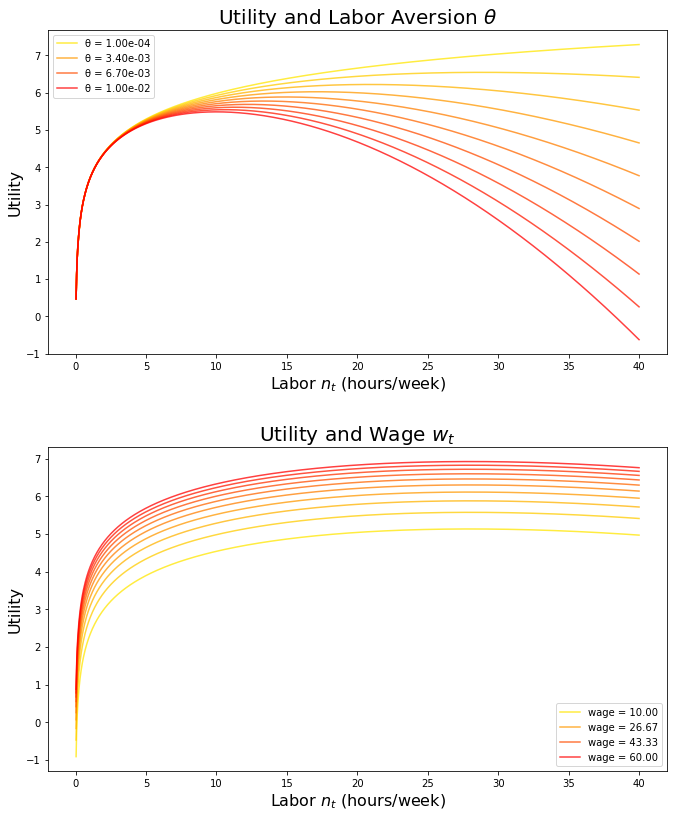

In [5]:
# check out utility function

def plot_utility_func():

    # formatting
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    steps = 10

    # utility function and labor aversion
    θ_min, θ_max = 1e-4, 1e-2
    θ_grid = np.linspace(θ_min, θ_max, steps)

    for θ in θ_grid:

        # equilibrium consumption, by equation (1.5)
        c_grid =  A * n_grid_default
        u_grid = u_vec(c_grid, n_grid_default, θ=θ)

        # plotting arguments
        scale = 0.1 + 0.9 * (θ-θ_min)/(θ_max-θ_min)
        kwargs = dict(c = cmap(scale), alpha = 0.75)

        # add label for first and last
        if θ in (θ_min, θ_max, *θ_grid[::int(steps/3)]):

            kwargs['label'] = f'θ = {θ:.2e}'

        # plot utility function
        axes[0].plot(n_grid_default, u_grid, **kwargs)

    axes[0].set_title('Utility and Labor Aversion $\\theta$', fontsize=20)

    axes[0].set_xlabel('Labor $n_t$ (hours/week)', fontsize=16)
    axes[0].set_ylabel('Utility', fontsize=16)

    axes[0].legend()


    # utility function and wage
    w_min, w_max = 10, 60
    w_grid = np.linspace(w_min, w_max, steps)

    for w in w_grid:

        # equilibrium consumption, by equation (1.5)
        c_grid =  w * n_grid_default
        u_grid = u_vec(c_grid, n_grid_default)

        # plotting arguments
        scale = 0.1 + 0.9 * (w-w_min)/(w_max-w_min)
        kwargs = dict(c = cmap(scale), alpha = 0.75)

        # add label for first and last
        if w in (w_min, w_max, *w_grid[::int(steps/3)]):

            kwargs['label'] = f'wage = {w:.2f}'

        # plot utility function
        axes[1].plot(n_grid_default, u_grid, **kwargs)

    axes[1].set_title('Utility and Wage $w_t$', fontsize=20)

    axes[1].set_xlabel('Labor $n_t$ (hours/week)', fontsize=16)
    axes[1].set_ylabel('Utility', fontsize=16)
    axes[1].legend()


    plt.tight_layout(pad=3)
    plt.show()
    
plot_utility_func()

### Solve Pre-Infection Economy Model

Here we solve the representative agent's policy function in the pre-infection economy. As mentioned on page 16 of the paper, the parameters were chosen so that the pre-epidemic the representative agent works 28 hours and consumes \\$58,000/52 $\approx$ \\$1115.38 per week.

In [6]:
# solve pre-infection model

@njit
def solve_pre_infection(n_grid=n_grid_default, # labor state space
                        max_iter=10_000, # max iterations
                        threshold=1e-5 # convergence threshold
                       ):
    '''
    Solves value function and optimal policies for pre-infection economy representative agent.
    
    Parameters
    ---------
        n_grid : numpy array (default = n_grid_default)
            labor state space
            
        max_iter : int (default = 10_000)
            max iterations for solving model
            
        threshold : float (default = 1e-5)
            convergence threshold of value function
            
    Returns
    -------
        V : float
            value function at convergence
            
        n : float
            optimal labor policy
            
        c : float
            optimal consumption policy
        
        error : float
            convergence error of value function
    '''
    # value-to-go
    V = 0
    
    # consumption grid (by equation 1.5)
    c_grid = A * n_grid
    
    # utility grid
    u_grid = u_vec(c_grid, n_grid)
    
    for _ in range(max_iter):

        # value-to-go in new iteration
        V_prev = V

        # value grid
        v_grid = u_grid + β * V_prev

        # optimal labor choice
        best = np.argmax(v_grid)

        # update value-to-go
        V = v_grid[best]

        # convergence error
        error = np.abs(V - V_prev)
        
        if error < threshold:
            break
    
    # return optimal policy
    return V, n_grid[best], c_grid[best], error

In [7]:
# pre-infection economy policy

V, n, c, error = solve_pre_infection()

print(textbf('Pre-infection Economy'))
print(textbf('-'*30))

print(f'Convergence value: \t {V:.2f}')
print(f'Optimal labor: \t\t {n:.2f} hrs/week')
print(f'Optimal consumption: \t $ {c:.2f}/week')

print(f'\nConvergence error: \t {error:.2e}')

Pre-infection Economy
------------------------------
Convergence value: 	 8301.72
Optimal labor: 		 28.00 hrs/week
Optimal consumption: 	 $ 1115.38/week

Convergence error: 	 2.54e-03


<a id="epidemic-dynamics"></a>

---
[**Back to Contents**](#contents)

# 2: Epidemic Dynamics

This section defines the population dynamics of different household agent types during the epidemic in the SIR-Macro model. [**Section 5**](#ee-sim) simulates the evolution of epidemic with the SIR-Macro model.

### Transmission Rate
In any period, the newly infected percentage of the population is given by:

$$
\begin{equation*}
        T_t = \pi_1(S_t C^s_t)(I_t C^I_t) + \pi_2 (S_t N^S_t)(I_t N^I_t) + \pi_3 S_t I_t \tag{2.1}
\end{equation*}
$$

where:

* $S_t C^s_t$ and $I_t C^I_t$ are respectively total consumption of the susceptible and infected. $\pi_1$ is the probability of infection from consumption interactions (e.g., when shopping).

* $S_t N^s_t$ and $I_t N^I_t$ are total labor of the susceptible and infected. $\pi_2$ is the probability of infection from labor interactions (e.g., at work).

* $S_t$ and $I_t$ are percentage population of the susceptible and infected. $\pi_3$ is the probability of infection from other interactions.


### Population

Evolution of susceptible $S_t$, infected $I_t$, recovered $R_t$, and deceased $D_t$ populations are given by:

$$
\begin{align}
    S_{t+1} &= S_{t} - T_{t} \tag{2.2} \\
    I_{t+1} &= I_{t} + T_{t} - (\pi_r + \pi_d) I_{t} \tag{2.3} \\
    R_{t+1} &= R_{t} + \pi_r I_{t} \tag{2.4} \\
    D_{t+1} &= R_{t} + \pi_d I_{t} \tag{2.5} \\
\end{align}
$$

Evolution of total population $Pop_{t}$, where $Pop_0 = 1$:
$$
    Pop_{t+1} = Pop_{t} - \pi_d I_{t} \tag{2.6}
$$

### Epidemic Parameters

Parameters value are taken from Section 4.1 of Eichenbaumn, Rebelo, Trabandt. The specific parameters below are discussed on pages 14 and 15.

In [8]:
# epidemic parameters

# transmission probabilities
π_1 = 7.84e-8 # from consumption (shopping)
π_2 = 1.24e-4 # from labor (working)
π_3 = 0.39    # from normal interaction


π_r = 0.2          # recovery rate
π_d = 7 * 0.005/18 # mortality rate

<a id="epidemic-household"></a>

---

[**Back to Contents**](#contents)

# 3: Household Dynamics in Epidemic

This section defines and solves the policy functions for representative household agents in the epidemic. [**Section 4**](#household-results) analyzes the solutions. [**Section 5**](#ee-sim) simulates the labor and consumption choices over the progression of the epidemic.


### Household Budget Constraint

For each household type $j \in {s, i, r}$, the budget constraint is similar to pre-infection economy:

$$
\begin{align}
    (1 + \mu_t)c^j_t &= w_t \phi^j n^j_t + \Gamma_t
\end{align}
$$

where $c^j_t$ and $n^j_t$ are consumption and labor for type $j$ households, and $\phi^j$ is productivity. We assume that susceptible and recovered households are fully productive $\phi^s = \phi^r = 1$, and infected households are not $\phi^i < 1$.

<!-- 
### Firms

Continuum of representative firm produces consumption goods $C_t$ with labor $N_t$ and technology $A$:

$$
\begin{align}
    C_t &= A N_t \\
    S_t c^s_t + I_t c^i_t + R_t c^r_t &= A (S_t N^s_t \phi^s + I_t N^i_t \phi^i + R_t N^r_t )
\end{align}
$$

and chooses labor to maximize profits:

$$
\begin{align}
    \Pi_t &= A N_t - w_t N_t
\end{align}
$$


### Government

Government's budget constraint is given by:
$$
\begin{align}
    \mu_t (S_t c^s_t + I_t c^i_t + R_t c^r_t) &= \Gamma_t (S_t + I_t + R_t)
\end{align}
$$


$$
\begin{align}
\end{align}
$$
  -->
 
### Market Equilibrium
<!-- 
In equilibrium,
$$
\begin{align}
    C_t &= S_t c^s_t + I_t c^i_t + R_t c^r_t \\
    AN_t &= A (\phi_s n^s_t + \phi_i n^i_t + \phi_r n^r_t)
\end{align}
$$

Household constraint in equilibrium, by equation (3.1):

$$
\begin{align}
    (1 + \mu_t)c^j_t &= w_t \phi^j n^j_t + \Gamma_t
    \\
    (1 + \mu_t)(c^s_t + c^i_t + c^r_t)
    &= w_t (\phi_s n^s_t + \phi_i n^i_t + \phi_r n^r_t)
    + \frac{\mu_t (S_t c^s_t + I_t c^i_t + R_t c^r_t)}{(S_t + I_t + R_t)}
    \\
    (1 + \mu_t)(c^s_t + c^i_t + c^r_t)(S_t + I_t + R_t)
    &= w_t (\phi_s n^s_t + \phi_i n^i_t + \phi_r n^r_t) (S_t + I_t + R_t)
    + \mu_t (S_t c^s_t + I_t c^i_t + R_t c^r_t)
\end{align}
$$
 -->
For simplicity, we will assume the agents' consumption is constrained only by wage, productivity, and labor in equilibrium (constraint is independent of tax or government transfer), similar to the pre-infection agent:

$$
\begin{equation*}
    c^j_t = A \phi^j n^j_t
\tag{3.1}
\end{equation*}
$$

<a id="recovered"></a>

## Recovered Agent

The lifetime utiltiy of a recovered agent is given by:

$$
\begin{equation*}
    U^r_t = u(c^r_t, n^r_t) + \beta U^r_{t+1}
\label{eq:u_s} \tag{3.2}
\end{equation*}
$$


First order conditions are detailed in [**Appendix B**](#appendix-recovered).

In [9]:
# recovered policy

@njit
def solve_recovered(n_grid = n_grid_default, # labor state space
                    ϕ = 1.0,                 # productivity
                    max_iter = 10_000,       # maximum iterations
                    threshold = 1e-5         # convergence threshold
                   ):
    '''
    Solves value function and optimal policies for the recovered representative agent in an epidemic.
    
    Parameters
    ---------
        n_grid : numpy array (default = n_grid_default)
            labor state space
            
        ϕ : float (default = 1.0)
            labor productivity from equation (3.1)
        
        max_iter : int (default = 10_000)
            max iterations for solving model
            
        threshold : float (default = 1e-5)
            convergence threshold of value function
            
    Returns
    -------
        Vr : float
            recovered agent value at convergence
            
        nr : float
            optimal labor policy
            
        cr : float
            optimal consumption policy
        
        error : float
            convergence error of value function
    '''
    
    # value-to-go
    Vr = 0
    
    # consumption grid, by equation (3.1)
    cr_grid = A * ϕ * n_grid
    
    # current period utility grid
    ur_grid = u_vec(cr_grid, n_grid)
    
    for _ in range(max_iter):

        # previous iteration
        V_prev = Vr

        # value grid, by equation (3.2)
        v_grid = ur_grid + β * V_prev

        # optimal policy index
        best = np.argmax(v_grid)

        # update value-to-go
        Vr = v_grid[best]

        # check convergence
        error =  np.abs(Vr - V_prev)
        
        if error < threshold:
            break
            
    # assign optimal labor and consumption
    nr = n_grid[best]
    cr = cr_grid[best]
    
    return Vr, nr, cr, error

<a id="infected"></a>

## Infected Agent

The lifetime utiltiy of a infected agent is given by:

$$
\begin{equation*}
    U^i_t = u(c^i_t, n^i_t) + \beta [(1 - \pi_r - \pi_d) U^i_{t+1} + \pi_r U^r_{t+1} + \pi_d U^d]
\label{eq:u_s} \tag{3.3}
\end{equation*}
$$

We assume life-time utility of deceased agent $U^d$ to be zero. 

First order conditions are detailed in [**Appendix C**](#appendix-infected).

In [10]:
# infected policy

@njit
def solve_infected(Vr,                      # recovered value
                   Vd = 0,                  # deceased value
                   n_grid = n_grid_default, # labor state space
                   ϕ = 0.8,                 # productivity
                   max_iter = 10_000,       # maximum iterations
                   threshold = 1e-5         # convergence threshold
                  ):
    '''
    Solves value function and optimal policies for the infected representative agent in an epidemic.
    
    Parameters
    ---------
        Vr : float
            lifetime value of recovered agent
            
        Vd : float (default = 0)
            lifetime value of deceased agent
        
        n_grid : numpy array (default = n_grid_default)
            labor state space
        
        ϕ : float (default = 0.8)
            labor productivity from equation (3.1)
            
        max_iter : int (default = 10_000)
            max iterations for solving model
            
        threshold : float (default = 1e-5)
            convergence threshold of value function
            
    Returns
    -------
        Vi : float
            infected agent value at convergence
            
        ni : float
            optimal labor policy
            
        ci : float
            optimal consumption policy
        
        error : float
            convergence error of value function
    '''

    # value-to-go
    Vi = 0
    
    # consumption grid, by equation (3.1)
    ci_grid = A * ϕ * n_grid
    
    # current period utility grid
    ui_grid = u_vec(ci_grid, n_grid)
    
    
    for _ in range(max_iter):

        # previous iteration
        V_prev = Vi

        # value grid, equation (3.3)
        v_grid = ui_grid + β * ((1 - π_r - π_d) * V_prev + π_r * Vr + π_d * Vd)

        # optimal policy index
        best = np.argmax(v_grid)

        # update value-to-go
        Vi = v_grid[best]

        # check convergence
        error =  np.abs(Vi - V_prev)
        
        if error < threshold:
            break
            
    # assign optimal labor and consumption
    ni = n_grid[best]
    ci = ci_grid[best]
            
    return Vi, ni, ci, error

<a id="susceptible"></a>

## Susceptible Agent

The lifetime utiltiy of a susceptible agent is given by:

$$
\begin{equation*}
    U^s_t = u(c^s_t, n^s_t) + \beta [(1 - \tau_t) U^s_{t+1} + \tau_t U^i_{t+1}]
\label{eq:u_s} \tag{3.4}
\end{equation*}
$$

where $\tau_t$ is the probability of a susceptible person becoming infected:

$$
\begin{equation*}
    \tau_t = \pi_1 c^s_t (I_t c^I_t) + \pi_2 n^s_t (I_t n^I_t) + \pi_3 I_t
\label{eq:tau} \tag{3.5}
\end{equation*}
$$

First order conditions are detailed in [**Appendix D**](#appendix-susceptible).

### Susceptible Agent Model Setup

Here we setup the model for the susceptible agent's policy function, and solve the policy function model for the other agents (the solutions are required for solving the susceptible agent's model). Analysis of the solutions are presented in [**Section 4**](#household-results).

The code structure is a little messy, but allows saving the model while it's still in progress of being solved and continuing to solve. This saving feature is necessary for solving the model with more granular state spaces for susceptible $S_t$ and infected populations $I_t$, which can take several hours for the model to converge. In the model below we solve the model with a 501x501 state space grid.

In [11]:
# initialize new model / load previous model

new_model = False

# for training previously initiated model
load_file = 'SIR-Macro_501x501.pickle'

# set-up new model
if new_model:
    
    # state space size for susceptible agent model
    size=(501, 501)
    
    # solve pre-infection economy model
    V0, n0, c0, error_0 = solve_pre_infection()

    # solve recovered agent model
    Vr, nr, cr, error_r = solve_recovered()
    
    # solve infected agent model
    Vi, ni, ci, error_i = solve_infected(Vr)
    
    # initialize susceptible agent value-to-go function
    Vs = np.zeros(size)
    
    # susceptible agent policy functions
    Ns = np.zeros(size) # labor policy
    Cs = np.zeros(size) # consumption policy
    
    # susceptible model iterations
    itr = 0
    
    print('New model initiated')
    

# load previously initialized model from pickle file to continue training
else:
    
    # load saved model (for continued training)
    with open(load_file, 'rb') as pickle_in:

        stored_results = pickle.load(pickle_in)
        pickle_in.close()
    
    # load pre-infection policy
    V0 =  stored_results['pre_infection']['lifetime_utility']
    n0 = stored_results['pre_infection']['labor']
    c0 = stored_results['pre_infection']['consumption']
    error_0 = stored_results['pre_infection']['convergence error']
    
    # load recovered policy
    Vr =  stored_results['recovered']['lifetime_utility']
    nr = stored_results['recovered']['labor']
    cr = stored_results['recovered']['consumption']
    error_r = stored_results['recovered']['convergence error']
    
    # load infected policy
    Vi = stored_results['infected']['lifetime_utility']
    ni = stored_results['infected']['labor']
    ci = stored_results['infected']['consumption']
    error_i = stored_results['infected']['convergence error']

    # load susceptible policy
    Vs = stored_results['susceptible']['lifetime_utility']
    Ns = stored_results['susceptible']['labor']
    Cs = stored_results['susceptible']['consumption']
    error_s = stored_results['susceptible']['convergence error']
    
    S_grid = stored_results['susceptible']['S_grid']
    I_grid = stored_results['susceptible']['I_grid']
    
    # susceptible model iterations
    itr = stored_results['susceptible']['iterations']

    size = Vs.shape
    
    time_str = dt.strftime(dt.now(), '%I:%M %p')
    print('Model loaded', time_str)
    print(load_file)

Model loaded 11:27 AM
SIR-Macro_501x501.pickle


In [12]:
# initalize some other parameters and
# create a numba helper function

# labor state space
n_grid = n_grid_default.copy()

# maximum iterations
max_iter = 10_000

# convergence threshold
threshold = 1.0

# productivity factor
ϕ_s = 1.0

# consumption grid, by equation (3.1)
cs_grid = A * ϕ_s * n_grid

# current period utility grid
us_grid = u_vec(cs_grid, n_grid)

# initialize next period value grid
n_states = len(n_grid)
v_prime_grid = np.zeros(n_states)

# susceptible, infected states length
S_states, I_states = size

# susceptible population state space
S_grid = np.linspace(0, 1, S_states)

# infected population state space
I_grid = np.linspace(0, 1, I_states)

@njit
def njit_helper(Vs, Ns, Cs, v_prime_grid, # policy functions
                n_grid, cs_grid, us_grid, # labor, consumption and utility states
                S_grid, I_grid, S_states, I_states # population states
               ):
    '''
    Helper function to increase calculation speed.
    '''

    V_prev = Vs.copy()
    
    # for each infected state
    for j in range(I_states):

        # transmission rate grid, by equation (3.5)
        τ_grid = I_grid[j] * (π_1 * cs_grid * ci + π_2 * n_grid * ni + π_3)

        # for each susceptible state
        for i in range(S_states):

            # if over 100% of total population
            if S_grid[i] + I_grid[j] > 1.00:

                # avoid this option
                Vs[i, j] = -1e10
                Ns[i, j] = np.nan
                Cs[i, j] = np.nan

                continue

            # newly transmitted population, by equation (2.1)
            T_grid = τ_grid * S_grid[i]

            # next-period susceptible population, by (2.2)
            S_prime_grid = S_grid[i] - T_grid

            # index array of next-period susceptible population
            S_prime_index = np.searchsorted(S_grid, S_prime_grid)

            # validate index array
            S_prime_index[S_prime_index >= S_states] = S_states - 1

            # next-period infected population, by (2.3)
            I_prime_grid = (1 - π_r - π_d) * I_grid[j] + T_grid

            # index array of next-period infected population
            I_prime_index = np.searchsorted(I_grid, I_prime_grid)

            # validate index array
            I_prime_index[I_prime_index >= I_states] = I_states - 1

            # next period value based on labor choice (numba does not support 2-D advanced indexing)
            for k in range(n_states):
                    # next period states
                    i_prime = S_prime_index[k]
                    j_prime = I_prime_index[k]
                    
                    v_prime_grid[k] = V_prev[i_prime, j_prime]

            # value function grid, by equation (3.4)
            v_grid = us_grid + β * ((1 - τ_grid) * v_prime_grid + τ_grid * Vi)

            # optimal policy index
            best = np.argmax(v_grid)

            # update value-to-go
            Vs[i, j] = v_grid[best]

            # assign optimal labor and consumption
            Ns[i, j] = n_grid[best]
            Cs[i, j] = cs_grid[best]
            
    
    # convergence error
    error_s =  np.abs(Vs - V_prev).sum()
            
    return Vs, Ns, Cs, V_prev, error_s

### Solve Susceptible Agent Model

Here we solve the susceptible agent's model with a dynamic programming method. The model training process can be paused at any time by interrupting the jupyter kernel, and resumed by re-running the cell.

In [32]:
# run cell to begin or continue solving model
# interrupt kernel to pause

# time and iteration count
t0 = dt.now()
local_itr = 0

# start message
print('New Model:')
print(new_model)

print('\nMax iterations:')
print(max_iter)
print('-'*30)

# for catching KeyboardInterrupt only
try:
    
    while itr < max_iter:
        
        # previous iteration
        Vs, Ns, Cs, V_prev, error_s = njit_helper(Vs, Ns, Cs, v_prime_grid,
                                                  n_grid, cs_grid, us_grid,
                                                  S_grid, I_grid, S_states, I_states)

        # total iterations for saved model
        itr += 1

        # iterations for timing average speed
        local_itr += 1

        # show progress
        if itr % 10 == 0:
            clear_output()

            # total runtime
            print('Runtime:')
            Δt = dt.now() - t0
            print(str(Δt))

            # average time per iteration
            print('\nAvg time per iteration')
            print(str(Δt / (local_itr)))

            print('\nMax iterations:')
            print(max_iter)

            print('-'*30)

        # print convergence error
        print(f'[Iter {itr}] error: {error_s:.3e}')

        # check error
        if error_s < threshold:
            break
            
    print('Max iteration/convergence reached')
    
# pause model
except KeyboardInterrupt:
    
    print('\nPaused by KeyboardInterrupt')

print('=' * 30)
print('\nProcess ended')

Runtime:
0:00:18.048249

Avg time per iteration
0:00:03.609650

Max iterations:
10000
------------------------------
[Iter 10000] error: 1.225e+00
Max iteration/convergence reached

Process ended


### Store Results

Store household policies with `pickle`.

In [33]:
# save models with pickle
save_pickle = True

if save_pickle:

    results_dict = {
        'parameters'  : {
            'beta'   : β,
            'A'      : A,
            'n_grid' : n_grid_default,
            'θ'      : θ_default,
            'π_1'    : π_1,
            'π_2'    : π_2,
            'π_3'    : π_3,
            'π_r'    : π_r,
            'π_d'    : π_d
        },
        'pre_infection' : {
            'lifetime_utility' : V0,
            'labor' : n0,
            'consumption' : c0,
            'convergence error' : error_0
        },
        'recovered' : {
            'lifetime_utility' : Vr,
            'labor' : nr,
            'consumption' : cr,
            'convergence error' : error_r
        },
        'infected' : {
            'lifetime_utility' : Vi,
            'labor' : ni,
            'consumption' : ci,
            'convergence error' : error_i
        },
        'susceptible' : {
            'lifetime_utility' : Vs,
            'labor' : Ns,
            'consumption' : Cs,
            'convergence error' : error_s,
            'S_grid' : S_grid,
            'I_grid' : I_grid,
            'iterations' : itr
        }
    }


#     pickle_time = dt.strftime(dt.now(), '%Y%m%d_%H%M%S')
#     file_name = f'SIR-Macro_{pickle_time}_{ilen}x{jlen}.pickle'
    
    ilen, jlen = size
    file_name = f'SIR-Macro_{ilen}x{jlen}.pickle'
    
    with open(file_name, 'wb') as f:

        pickle.dump(results_dict, f)

        f.close()

    time_str = dt.strftime(dt.now(), '%I:%M %p')
    print('Model saved', time_str)
    print(f'File: "{file_name}"')
    
    print(f'Convergence error: {error_s:.2f}')

Model saved 12:52 PM
File: "SIR-Macro_501x501.pickle"
Convergence error: 1.23


<a id='household-results'></a>

---
[**Back to Contents**](#contents)

# 4: Household Dynamics Results

This section analyzes the results from the representative agent models described and solved in [**Section 3**](#epidemic-household).

### Pre-Infection Agent Policy

Below we use the labor and consumption policies of the representative agent in the pre-infection economy as a benchmark for the SIR agents. There are no inter-temporal dynamics in the economy model (everything must be consumed in current period. Agents cannot influence consumption in other periods).

In [34]:
# show results of pre-infection agent policy

print(textbf('\nPre-infection Economy'))
print(textbf('-'*30))

print(f'Optimal labor: \t\t {n0:.2f} hrs/week')
print(f'Optimal consumption: \t $ {c0:.2f}/week')

print(f'\nConvergence value: \t {V0:.2f}')
print(f'Convergence error: \t {error_0:.2e}')


Pre-infection Economy
------------------------------
Optimal labor: 		 28.00 hrs/week
Optimal consumption: 	 $ 1115.38/week

Convergence value: 	 8301.72
Convergence error: 	 2.54e-03


### Recovered Agent Policy

The labor and consumption policies for the recovered agent are the same as the pre-infection agent.

In [35]:
# show results of recovered agent policy

print(textbf('\nRecovered Agent Policy'))
print(textbf('-'*30))

print(f'Optimal labor: \t\t {nr:.2f} hrs/week')
print(f'Optimal consumption: \t $ {cr:.2f}/week')

print(f'\nConvergence value: \t {Vr:.2f}')
print(f'Convergence error: \t {error_r:.2e}')


Recovered Agent Policy
------------------------------
Optimal labor: 		 28.00 hrs/week
Optimal consumption: 	 $ 1115.38/week

Convergence value: 	 8301.72
Convergence error: 	 2.54e-03


### Infected Agent Policy

The labor policy for the infected agent is the same as the recovered and pre-infection agent. However, consumption is lower from the scaling of his productivity factor $\phi^i = 0.8$. The lower productivity factor essentially discounts his wage, but as we saw with the behaviour of the utility function, changes in wage does not change optimal labor choice.

In [36]:
# show results of infected agent policy

print(textbf('\nInfected Agent Policy'))
print(textbf('-'*30))

print(f'Optimal labor: \t\t {ni:.2f} hrs/week')
print(f'Optimal consumption: \t $ {ci:.2f}/week')

print(f'\nConvergence value: \t {Vi:.2f}')
print(f'Convergence error: \t {error_i:.2e}')


Infected Agent Policy
------------------------------
Optimal labor: 		 28.00 hrs/week
Optimal consumption: 	 $ 892.30/week

Convergence value: 	 8221.01
Convergence error: 	 9.20e-06


### Susceptible Agent Policy

The labor policy of susceptible agent is the same as the pre-infection, recovered, and infected when the infected agent population $I_t = 0$.

As seen in the color gradient, there is significant calculation error in the results. This is likely due to the limited granularity of the population states $S_t$ and $I_t$, which also impedes on the runtime for solving the model.

However, we would expect the optimal labor to increase at extremeties of population states (when $S_t$ and $I_t$ are close to 0 or 1) as the probabililty of transmission is low in these states. In the results, this is generally true for high susceptible population states and low infected population states.

As with the other agent types, the consumption policy is just the labor policy scaled by wage.

In [37]:
# show results of susceptible agent policy

print(textbf('\nSusceptible Agent Policy'))
print(textbf('-' * 30))

i_step = int(I_grid.size / 10)
s_step = int(S_grid.size / 10)

policy_dfs = {}

for label, func in zip(['Optimal Labor, n', 'Optimal Consumption, c', 'Convergence Value, v'],[Ns, Cs, Vs]):

    df = pd.DataFrame(func,
                        columns=[['Infected Population %']*len(I_grid), I_grid],
                        index=[['Susceptible Population %']*len(S_grid), S_grid])
    
    name, abbrev = label.split(', ')
    
    df = df.replace(-1e10, np.nan)
    
    policy_dfs[abbrev] = df
    
    print(textbf(f'\n\n\n{name}'))

    display(df.iloc[::i_step, ::s_step].round(2))
    
    print('-'*20)

print(textbf(f'\nConvergence error: \t {error_s:.2e}'))


Susceptible Agent Policy
------------------------------



Optimal Labor


Infected Population %                       \
                                               0.0    0.1    0.2    0.3   
Susceptible Population % 0.0                  28.0  25.56  24.20  23.44   
                         0.1                  28.0  33.56  25.12  24.72   
                         0.2                  28.0  26.60  25.84  24.44   
                         0.3                  28.0  23.92  23.92  23.92   
                         0.4                  28.0  26.32  26.32  28.24   
                         0.5                  28.0  27.32  24.56  25.64   
                         0.6                  28.0  28.24  28.24  25.16   
                         0.7                  28.0  29.00  27.12  27.48   
                         0.8                  28.0  25.92  27.60    NaN   
                         0.9                  28.0  26.76    NaN    NaN   
                         1.0                  28.0    NaN    NaN    NaN   

                                                                               
                                0.4    0.5    0.6    0.7    0.8    0.9    1.0  
Susceptible Population % 0.0  23.28  23.32  23.56  23.88  24.32  24.76  25.24  
                         0.1  25.60  23.84  24.96  25.24  24.64  25.92    NaN  
                         0.2  23.12  25.44  25.64  25.88  25.12    NaN    NaN  
                         0.3  25.88  26.00  25.68  26.40    NaN    NaN    NaN  
                         0.4  26.32  26.32  25.00    NaN    NaN    NaN    NaN  
                         0.5  26.16  26.48    NaN    NaN    NaN    NaN    NaN  
                         0.6  28.24    NaN    NaN    NaN    NaN    NaN    NaN  
                         0.7    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
                         0.8    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
                         0.9    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
                         1.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN

--------------------



Optimal Consumption


Infected Population %                             \
                                               0.0      0.1      0.2      0.3   
Susceptible Population % 0.0               1115.38  1018.18   964.01   933.73   
                         0.1               1115.38  1336.86  1000.66   984.72   
                         0.2               1115.38  1059.61  1029.34   973.57   
                         0.3               1115.38   952.85   952.85   952.85   
                         0.4               1115.38  1048.46  1048.46  1124.94   
                         0.5               1115.38  1088.29   978.35  1021.37   
                         0.6               1115.38  1124.94  1124.94  1002.25   
                         0.7               1115.38  1155.21  1080.33  1094.67   
                         0.8               1115.38  1032.52  1099.45      NaN   
                         0.9               1115.38  1065.98      NaN      NaN   
                         1.0               1115.38      NaN      NaN      NaN   

                                                                           \
                                  0.4      0.5      0.6      0.7      0.8   
Susceptible Population % 0.0   927.36   928.95   938.51   951.26   968.79   
                         0.1  1019.78   949.67   994.28  1005.44   981.53   
                         0.2   920.99  1013.40  1021.37  1030.93  1000.66   
                         0.3  1030.93  1035.71  1022.96  1051.64      NaN   
                         0.4  1048.46  1048.46   995.88      NaN      NaN   
                         0.5  1042.08  1054.83      NaN      NaN      NaN   
                         0.6  1124.94      NaN      NaN      NaN      NaN   
                         0.7      NaN      NaN      NaN      NaN      NaN   
                         0.8      NaN      NaN      NaN      NaN      NaN   
                         0.9      NaN      NaN      NaN      NaN      NaN   
                         1.0      NaN      NaN      NaN      NaN      NaN   

                                                
                                  0.9      1.0  
Susceptible Population % 0.0   986.31  1005.44  
                         0.1  1032.52      NaN  
                         0.2      NaN      NaN  
                         0.3      NaN      NaN  
                         0.4      NaN      NaN  
                         0.5      NaN      NaN  
                         0.6      NaN      NaN  
                         0.7      NaN      NaN  
                         0.8      NaN      NaN  
                         0.9      NaN      NaN  
                         1.0      NaN      NaN

--------------------



Convergence Value


Infected Population %                             \
                                               0.0      0.1      0.2      0.3   
Susceptible Population % 0.0               8301.84  8231.00  8228.52  8226.74   
                         0.1               8301.84  8228.15  8226.62  8225.05   
                         0.2               8301.84  8226.58  8225.16  8224.26   
                         0.3               8301.84  8225.42  8224.35  8223.52   
                         0.4               8301.84  8224.56  8223.61  8222.96   
                         0.5               8301.84  8223.80  8223.01  8222.51   
                         0.6               8301.84  8223.26  8222.57  8222.16   
                         0.7               8301.84  8222.77  8222.28  8221.89   
                         0.8               8301.84  8222.39  8222.00      NaN   
                         0.9               8301.84  8222.13      NaN      NaN   
                         1.0               8301.84      NaN      NaN      NaN   

                                                                           \
                                  0.4      0.5      0.6      0.7      0.8   
Susceptible Population % 0.0  8225.22  8224.12  8223.28  8222.67  8222.20   
                         0.1  8223.92  8223.13  8222.53  8222.11  8221.78   
                         0.2  8223.36  8222.66  8222.19  8221.85  8221.61   
                         0.3  8222.82  8222.29  8221.91  8221.65      NaN   
                         0.4  8222.39  8221.99  8221.70      NaN      NaN   
                         0.5  8222.07  8221.76      NaN      NaN      NaN   
                         0.6  8221.82      NaN      NaN      NaN      NaN   
                         0.7      NaN      NaN      NaN      NaN      NaN   
                         0.8      NaN      NaN      NaN      NaN      NaN   
                         0.9      NaN      NaN      NaN      NaN      NaN   
                         1.0      NaN      NaN      NaN      NaN      NaN   

                                               
                                  0.9     1.0  
Susceptible Population % 0.0  8221.86  8221.6  
                         0.1  8221.56     NaN  
                         0.2      NaN     NaN  
                         0.3      NaN     NaN  
                         0.4      NaN     NaN  
                         0.5      NaN     NaN  
                         0.6      NaN     NaN  
                         0.7      NaN     NaN  
                         0.8      NaN     NaN  
                         0.9      NaN     NaN  
                         1.0      NaN     NaN

--------------------

Convergence error: 	 1.23e+00


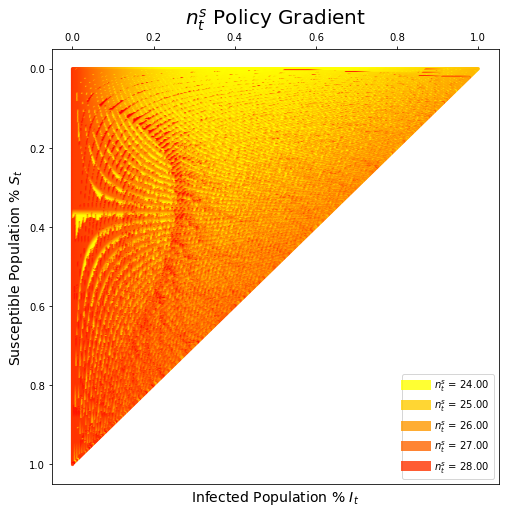

In [38]:
def plot_policy_gradient(policy=Ns,
                         S_grid=S_grid,
                         I_grid=I_grid,
                         policy_type='$n^s_t$',
                         cmap= 'autumn_r'
                        ):

    fig, ax = plt.subplots(figsize=(8, 8))
    
    cmap = plt.get_cmap(cmap)
    
    # mean
    tmp = policy[~np.isnan(policy)]
    mean_val = tmp.mean() # mean value
    max_val = 28 # tmp.max()
    min_val = 24 # tmp[tmp >= 0].min()
    
    # color scale function
    cscale = lambda val: 0.8 * (val - min_val) / (max_val - min_val)

    # plot grid
    for i in range(S_grid.size):

        # non-nan policies
        index = ~np.isnan(policy[i])
        
        # compute color scale
        scale = cscale(policy[i][index])

        x = I_grid[index]
        y = S_grid[i] * np.ones(I_grid.size)
        y = y[index]

        ax.scatter(x, y, c=cmap(scale), alpha=0.8, s=5)

    # labels
    ax.set_ylabel('Susceptible Population % $S_t$', fontsize=14)
    ax.set_xlabel('Infected Population % $I_t$', fontsize=14)
    ax.set_title(f'{policy_type} Policy Gradient', fontsize=20)
    
    # x-axis tick marks on top
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # color legend
    label_grid = np.linspace(min_val, max_val, 5)
    custom_lines = [
        Line2D([0], [0], color=cmap(cscale(val)), lw=10, alpha=0.8)
        for val in label_grid
                   ]
    
    labels = [f'{policy_type} = {val:.2f}' for val in label_grid]
    ax.legend(custom_lines, labels)
    
    plt.show()
    
# plot labor policy
plot_policy_gradient()

<a id='ee-sim'></a>

---
[**Back to Contents**](#contents)

# 5: Epidemic Simulation

This section simulates the SIR-Macro model from [**Section 2**](#epidemic-dynamics) and the susceptible agent's labor/consumption choices from [**Section 3**](#epidemic-household).


In [39]:
# for accessing susceptible policy function
def susceptible_policy(policy_grid,
             S_t, I_t, # infection and susceptible
             S_grid=S_grid,
             I_grid=I_grid
            ):
    '''
    Returns policy value for susceptible agent
    given infected and susceptible population.
    '''
    
    # find susceptible index
    i = np.searchsorted(S_grid, round(S_t, 4)) - 1
    
    # find infected index
    j = np.searchsorted(I_grid, round(I_t, 4)) - 1
    
    # validate indices
    i = min(i, S_grid.size - 1) 
    j = min(j, I_grid.size - 1)
    
    change_i = True
    
    # back track for nan policy (susceptible and infection populations > 100%)
    while np.isnan(policy_grid[i, j]):
        
        if change_i:
            i -= 1
        else:
            j -= 1
        change_i = not change_i
    
    # return susceptible agent policy and indices
    return policy_grid[i, j], i, j

In [40]:
H = 72 # periods (weeks)

pop = np.zeros(H)
pop[0] = 1

# susceptible, infected, recovered, deceased
S, I, R, D = (np.zeros(H) for _ in range(4))

# susceptible agent policy during pandemic
ns_evo = np.zeros(H)
cs_evo = np.zeros(H)

# initial distribution
S[0], I[0] = 0.999, 0.001

T = np.zeros(H) # transmission rate

for t in range(H - 1):
    
    # find susceptible agent policy values
    ns, i, j = susceptible_policy(Ns, S[t], I[t]) # labor policy
    cs = Cs[i, j] # consumption policy
    
    # add to evolution series
    ns_evo[t] = ns
    cs_evo[t] = cs
    
    # transmission rate, by equation (2.1)
    T[t] = (π_1 * S[t] * cs * I[t] * ci +
            π_2 * S[t] * ns * I[t] * ni +
            π_3 * S[t] * I[t])
    
    # SIR dynamics, equation (2.2 to 2.5)
    S[t + 1] = S[t] - T[t]
    I[t + 1] = (1 - π_r - π_d) * I[t] + T[t]
    R[t + 1] = R[t] + π_r * I[t]
    D[t + 1] = D[t] + π_d * I[t]
    
    # population dyanmics, equation (2.6)
    pop[t + 1] = pop[t] - π_d * I[t]
    
ns_evo[t+1] = ns
cs_evo[t+1] = cs

## Epidemic Progression


We an see a trend of decreasing labor choice for the susceptible agent towards the "peak" of the epidemic (when infected population is highest), and increasing back to the benchmark labor choice (pre-infection) as the population recovers.

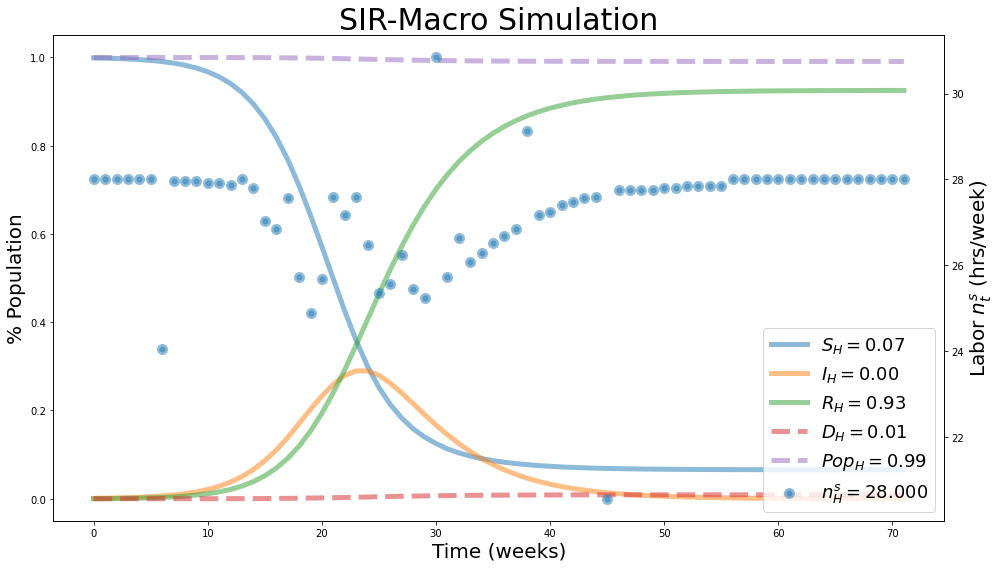


Simulation Summary


,S_t,I_t,R_t,D_t,Pop_t,n^s_t,c^s_t
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.341280,0.064256,0.588740,0.005724,0.994276,27.299444,1087.473369
std,0.378006,0.090449,0.388394,0.003776,0.003776,1.316453,52.440891
min,0.065611,0.000127,0.000000,0.000000,0.991004,20.560000,819.007600
25%,0.066284,0.001878,0.112243,0.001091,0.991039,26.840000,1069.171400
50%,0.084479,0.014586,0.836093,0.008129,0.991871,27.800000,1107.413000
75%,0.724029,0.095009,0.921656,0.008961,0.998909,28.000000,1115.380000
max,0.999000,0.289646,0.925267,0.008996,1.000000,30.840000,1228.511400



Simulation Results


,S_t,I_t,R_t,D_t,Pop_t,n^s_t,c^s_t
Period (week),,,,,,,
0,0.999000,0.001000,0.000000,0.000000,1.000000,28.00,1115.3800
5,0.993258,0.004684,0.002038,0.000020,0.999980,28.00,1115.3800
10,0.967502,0.021023,0.011365,0.000110,0.999890,27.92,1112.1932
15,0.861085,0.086318,0.052091,0.000506,0.999494,27.04,1077.1384
20,0.571272,0.232975,0.193868,0.001885,0.998115,25.68,1022.9628
25,0.251949,0.279472,0.464067,0.004512,0.995488,25.36,1010.2156
30,0.125049,0.166724,0.701407,0.006819,0.993181,30.84,1228.5114
35,0.086333,0.077245,0.828369,0.008054,0.991946,26.52,1056.4242
40,0.073468,0.032883,0.885044,0.008605,0.991395,27.24,1085.1054


In [41]:
evo_data = np.array([S, I, R, D, pop])
var_names = 'S, I, R, D, Pop'.split(', ')

fig, ax1 = plt.subplots(figsize=(14, 8))

# instantiate second y-axis
ax2 = ax1.twinx()

# store plot objects for legend
lines = []

# plot population
for name, data in zip(var_names, evo_data):
    
    # formatting arguments
    kwargs = dict(alpha=0.5, lw=5)
    
    if name.lower() in ['pop', 'd']:
        kwargs['ls'] = '--'
    
    # plot line
    ln = ax1.plot(range(H), data, **kwargs)
    
    # add for twin axis legends
    lines.append(ln[0])

# labels
ax1.set_ylabel('% Population', fontsize=20)
ax1.set_xlabel('Time (weeks)', fontsize=20)
ax1.set_title('SIR-Macro Simulation', fontsize=30)


# plot scatter graph for susceptible agent labor policy
ln = ax2.scatter(range(H), ns_evo, alpha=0.5, lw=5, label='$n^s_t$')

ax2.set_ylabel('Labor $n^s_t$ (hrs/week)', fontsize=20)

# show legend
lines.append(ln) # add for twin axis legends
labels = [f'${l}_H = {d[-1]:.2f}$' for l, d in zip(var_names, evo_data)]
labels.append(f'$n^s_H = {ns_evo[-1]:.3f}$')
plt.legend(lines, labels, fontsize=18)

# formatting
fig.tight_layout()
plt.show()

# summarize data with pandas
data_series = {name+'_t' : data for name, data in zip(var_names, evo_data)}
data_series['n^s_t'] = ns_evo
data_series['c^s_t'] = cs_evo

df = pd.DataFrame(data_series, index=range(H))
df.index.name = 'Period (week)'

print(textbf('\nSimulation Summary'))
display(df.describe())

print(textbf('\nSimulation Results'))
display(df.iloc[::5])

## Simulation Policy Choices Between Agent Types

The recovered and infected agent labor policies are constant through the epidemic. The susceptible agent has the same labor choice at the beginning and end of the epidemic, but deviates as the epidemic progresses.

Except for instances of calculation error, the infected agent's consumption is lower than the other agents during the epidemic, which gives the infected agent lower utility. The susceptible agent's consumption policy follows the same trend as the for his labor policy, but always consuming more than the infected agent.

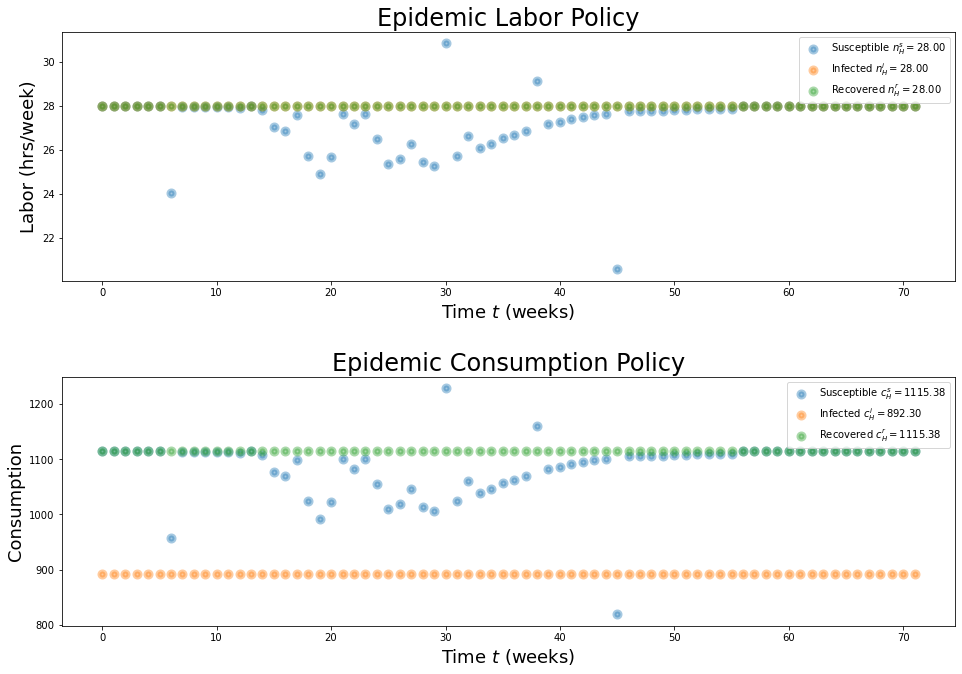

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

format_kwargs = dict(lw=4, alpha=0.4)
# labor
for data in  [ns_evo, ni * np.ones(H), nr * np.ones(H)]:
    ax1.scatter(range(H), data, **format_kwargs)

ax1.set_title('Epidemic Labor Policy', fontsize=24)
ax1.set_ylabel('Labor (hrs/week)', fontsize=18)
ax1.set_xlabel('Time $t$ (weeks)', fontsize=18)

ax1.legend([f'Susceptible $n^s_H = {ns:.2f}$',
            f'Infected $n^i_H = {ni:.2f}$',
            f'Recovered $n^r_H = {nr:.2f}$'])

# consumption
for data in [cs_evo, ci * np.ones(H), cr * np.ones(H)]:
    ax2.scatter(range(H), data, **format_kwargs)

ax2.set_title('Epidemic Consumption Policy', fontsize=24)
ax2.set_ylabel('Consumption', fontsize=18)
ax2.set_xlabel('Time $t$ (weeks)', fontsize=18)

ax2.legend([f'Susceptible $c^s_H = {cs:.2f}$',
            f'Infected $c^i_H = {ci:.2f}$',
            f'Recovered $c^r_H = {cr:.2f}$'])

plt.tight_layout(pad=3)
plt.show()

<a id="appendix-pre-infection"></a>

---

[**Back to Contents**](#contents)


## Appendix A

### First Order Conditions of the [Pre-Infection Economy Agent](#pre-infection-econ)


The Lagrangian is given by:
$$
\begin{align}
    \mathcal{L}
    &= \sum_{t=0}^{\infty} \beta^t u(c_t, n_t) - \lambda_t ((1 + \mu_t)c_t - w_t n_t - \Gamma_t) \\
\end{align}
$$

Taking FOC with respect to $c_t$:
$$
\begin{align}
    0 = \frac{\partial \mathcal{L}}{\partial c_t}
    &= \beta^t \frac{\partial u(c_t, n_t)}{\partial c_t} - \lambda_t (1 + \mu_t) \\
    &= \frac{\beta^t}{c_t} - \lambda_t (1 + \mu_t) \\
    \lambda_t &= \frac{\beta^t}{c_t (1 + \mu_t)} \tag{A1}
\end{align}
$$

Taking FOC with respect to $n_t$:
$$
\begin{align}
    0 = \frac{\partial \mathcal{L}}{\partial n_t}
    &= \beta^t \frac{\partial u(c_t, n_t)}{\partial n_t} + \lambda_t w_t \\
    &= -\beta^t \theta n_t + \lambda_t w_t \\
    \lambda_t &= \beta^t \theta n_t \frac{1}{w_t} \tag{A2}
\end{align}
$$

First order condition, by (A1) and (A2):
$$
\begin{align}
    \beta^t \theta n_t \frac{1}{w_t} &= \frac{\beta^t}{c_t (1 + \mu_t)} \\
    (1 + \mu_t) \theta n_t &= \frac{w_t}{c_t} \tag{A3}
\end{align}
$$

<a id="appendix-recovered"></a>

---

[**Back to Contents**](#contents)


## Appendix B

### First Order Condition of the [Recovered Agent](#recovered)

The lagrangian is
$$\begin{align}
    \mathcal{L}
    &= u(c^r_t, n^r_t) + \beta U^r_{t+1} - \lambda^r[(1 + \mu_t)c^r_t - w_t \phi^r n^r_t - \Gamma_t]
\end{align}$$


Taking FOC with respect to consumption:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial c^r_t} \\
    &= \frac{\partial u(c^r_t, n^r_t)}{\partial c^r_t} - \lambda^r (1 + \mu_t) \\
    &= \frac{1}{c^r_t} - \lambda^r (1 + \mu_t) \\
    \lambda^r &= \frac{1}{c^r_t (1 + \mu_t)} \tag{B1}
\end{align}
$$

Taking FOC with respect to labor:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial n^r_t} \\
    &= \frac{\partial u(c^r_t, n^r_t)}{\partial n^r_t} + \lambda^r w_t \phi^r \\
    &= -\theta n^r_t + \lambda^r w_t \phi^r \\
    \lambda^r &= \frac{\theta n^r_t}{w_t \phi^r} \tag{B2}
\end{align}
$$

By equations (B1) and (B2), we have
$$
\begin{align}
    \frac{\theta n^r_t}{w_t \phi^r} &= \frac{1}{c^r_t (1 + \mu_t)} \\
    (1 + \mu_t)\theta n^r_t &= \frac{w_t \phi^r}{c^r_t} \tag{B3}
\end{align}
$$

<a id="appendix-infected"></a>

---
[**Back to Contents**](#contents)

## Appendix C

### First Order Condition of the [Infected Agent](#infected)

The lagrangian is
$$\begin{align}
    \mathcal{L}
    &= u(c^i_t, n^i_t) + \beta [(1 - \pi_r - \pi_d) U^i_{t+1} + \pi_r U^i_{t+1} + \pi_d 0] - \lambda^i [(1 + \mu_t)c^i_t - w_t \phi^i n^i_t - \Gamma_t]
\end{align}$$


Taking FOC with respect to consumption:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial c^i_t} \\
    &= \frac{\partial u(c^i_t, n^i_t)}{\partial c^i_t} - \lambda^i(1 + \mu_t) \\
    &= \frac{1}{c^i_t} - \lambda^i(1 + \mu_t) \\
    \lambda^i &= \frac{1}{c^i_t (1 + \mu_t)} \tag{C1}
\end{align}
$$

Taking FOC with respect to labor:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial n^i_t} \\
    &= \frac{\partial u(c^i_t, n^i_t)}{\partial n^i_t} + \lambda^i w_t \phi^i \\
    &= -\theta n^i_t + \lambda^i w_t \phi^i \\
    \lambda^i &= \frac{\theta n^i_t}{w_t \phi^i} \tag{C2}
\end{align}
$$

By equations (C2) and (C3), we have
$$
\begin{align}
    \frac{\theta n^i_t}{w_t \phi^i} &= \frac{1}{c^i_t (1 + \mu_t)} \\
    (1 + \mu_t)\theta n^i_t &= \frac{w_t \phi^i}{c^i_t} \tag{C3}
\end{align}
$$

<a id="appendix-susceptible"></a>

---

[**Back to Contents**](#contents)


## Appendix D

### First Order Condition of the [Susceptible Agent](#susceptible)

The lagrangian is
$$\begin{align}
    \mathcal{L}
    &= u(c^s_t, n^s_t) + \beta [(1 - \tau_t) U^s_{t+1} + \tau_t U^i_{t+1}] \\
    &\quad - \lambda^s_{bt}[(1 + \mu_t)c^s_t - w_t \phi^s n^s_t - \Gamma_t] \\
    &\quad - \lambda_{rt} [\tau_t - \pi_1 c^s_t (I_t C^I_t) - \pi_2 n^s_t (I_t N^I_t) - \pi_3 I_t]
\end{align}$$


Taking FOC with respect to consumption:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial c^s_t} \\
    &= \frac{\partial u(c^s_t, n^s_t)}{\partial c^s_t} - \lambda^s_{bt}(1 + \mu_t) + \lambda_{rt} \pi_1 (I_t C^I_t) \tag{D1}
\end{align}
$$

Taking FOC with respect to labor:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial n^s_t} \\
    &= \frac{\partial u(c^s_t, n^s_t)}{\partial n^s_t} + \lambda^s_{bt} w_t \phi^s + \lambda_{rt} \pi_2 (I_t N^I_t) \tag{D2}
\end{align}
$$

Taking FOC with respect to infection rate:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial \tau_t} \\
    &= \beta (U^i_{t+1} - U^s_{t+1}) -\lambda_{rt} \tag{D3}
\end{align}
$$